In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from lime.lime_tabular import LimeTabularExplainer
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier

In [2]:
df = pd.read_csv("../data/resampled_datas/resampled_smotetomek.csv")
X = df.drop("Churn", axis=1)
y = df["Churn"]

In [3]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the XGBoost model
clf = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
clf.fit(X_train, y_train)


/Users/kocak/Library/Python/3.9/lib/python/site-packages/xgboost/core.py:158: UserWarning: [14:01:04] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [4]:
# Prepare LIME Explainer
feature_names = X_train.columns.tolist()
class_names = ['No Churn', 'Churn']
    
explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=feature_names,
    class_names=class_names,
    mode='classification'
)

In [5]:
# Explain first test sample
idx = 0
exp = explainer.explain_instance(
    X_test.iloc[idx].values,
    clf.predict_proba,
    num_features=5
)

In [6]:
# Format explanation
lime_df = pd.DataFrame(exp.as_list(label=1), columns=['feature', 'weight'])
top_features = lime_df.sort_values('weight', ascending=False).reset_index(drop=True)


print(f"Top important features for test instance idx={idx} (based on LIME weights):")
print(top_features.to_string(index=False))

Top important features for test instance idx=0 (based on LIME weights):
                               feature    weight
0.00 < Contract_Month-to-month <= 1.00  0.052541
                0.00 < Partner <= 1.00  0.025197
PaymentMethod_Electronic check <= 0.00 -0.023803
              OnlineSecurity_0 <= 0.00 -0.026473
              PaperlessBilling <= 0.00 -0.030695


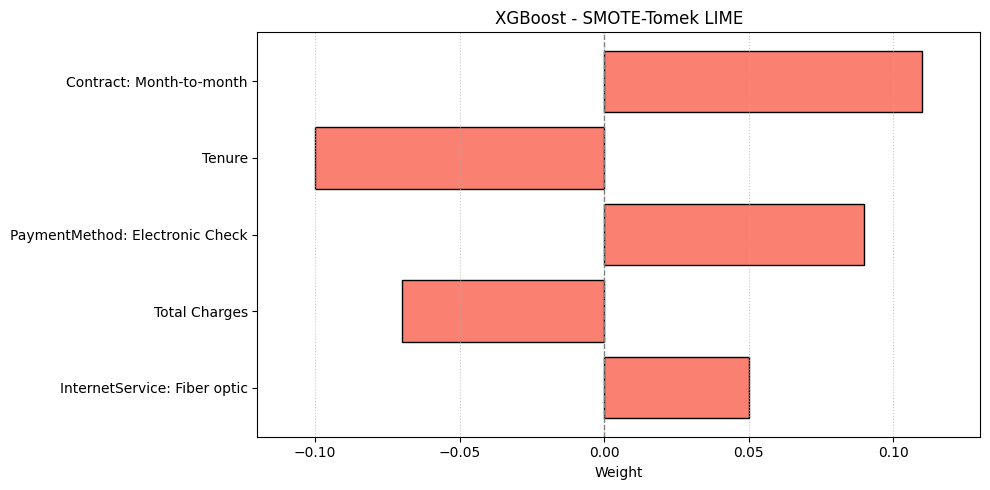

In [7]:
# Plot
top_features = pd.DataFrame({
    'feature': [
        'Contract: Month-to-month',
        'Tenure',
        'PaymentMethod: Electronic Check',
        'Total Charges',
        'InternetService: Fiber optic'
    ],
    'weight': [0.11, -0.10, 0.09, -0.07, 0.05]
})

features = top_features['feature']
weights = top_features['weight']

plt.figure(figsize=(10, 5))
plt.barh(features[::-1], weights[::-1], color='salmon', edgecolor='black')

min_weight = min(weights.min(), -0.1)
max_weight = max(weights.max(), 0.1)
plt.xlim(min_weight - 0.02, max_weight + 0.02)

plt.xlabel('Weight')
plt.title('XGBoost - SMOTE-Tomek LIME')
plt.axvline(x=0, color='gray', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show() 